In [1]:
import sys 
print(sys.version)

3.8.6rc1 (tags/v3.8.6rc1:08bd63d, Sep  7 2020, 23:10:23) [MSC v.1927 64 bit (AMD64)]


In [2]:
# python version 3.8.6rc1
import pandas as pd
import string
import util
import io
import os
from pprint import pprint
import spacy
import pickle
import re
import numpy as np

import warnings
warnings.filterwarnings(action='once')
#warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

import matplotlib
matplotlib.use("Agg")
import matplotlib.pyplot as plt

import nltk
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import gensim
import gensim.corpora as corpora
from gensim.corpora import Dictionary
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamodel import LdaModel

import pyLDAvis
import pyLDAvis.gensim_models
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import metrics
from sklearn.decomposition import LatentDirichletAllocation

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Willi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Willi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Willi\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Willi\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


# Descriptive Analysis

In [3]:
# Count number of rows with each label without considering combination
comments = pd.read_csv("train.csv")
comments.iloc[:, 2:].sum(axis=0)

c:\users\willi\appdata\local\programs\python\python38\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


toxic            15294
severe_toxic      1595
obscene           8449
threat             478
insult            7877
identity_hate     1405
dtype: int64

c:\users\willi\appdata\local\programs\python\python38\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<AxesSubplot:title={'center':'Labels Frequency'}>

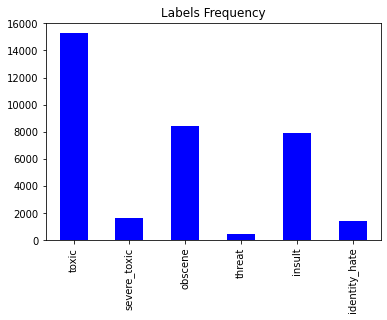

In [4]:
# Label Frequency
train_labels = comments[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']]
label_count = train_labels.sum()
label_count.plot(kind='bar', title='Labels Frequency', color='b')

In [5]:
# Count number of different combinations
comments[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].value_counts().reset_index(name='count')

c:\users\willi\appdata\local\programs\python\python38\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,toxic,severe_toxic,obscene,threat,insult,identity_hate,count
0,0,0,0,0,0,0,143346
1,1,0,0,0,0,0,5666
2,1,0,1,0,1,0,3800
3,1,0,1,0,0,0,1758
4,1,0,0,0,1,0,1215
5,1,1,1,0,1,0,989
6,1,0,1,0,1,1,618
7,0,0,1,0,0,0,317
8,0,0,0,0,1,0,301
9,1,1,1,0,1,1,265


| Combination | Count |
| --- | --- |
| Toxic | 5666 |
| Toxic + Obscene + Insult | 3800 |
| Toxic + Obscene | 1758 |
| toxic + Insult | 1215 |
| Toxic + Severe Toxic + Obscene + Insult | 989 |
| Toxic + Obscene + Insult + Identity Hate | 618 |
| ... | ... |
| Obscene + Threat + Insult | 2 |
| Obscene + Threat | 2 |
| Toxic + Severe Toxic + Threat + Identity Hate | 1 |
| Toxic + Severe Toxic + Threat + Insult | 1 |


In [6]:
print(comments.iloc[:, 2:].sum(axis=0))
#(comments.iloc[:, 2:].sum())
# merging different kinds of harmful indicators
comments['harmful'] = comments.iloc[:, 2:].sum(axis=1)
#comments[comments['harmful']!=0] = 1
df = comments[['comment_text',"harmful"]]#.copy()
#selected.dtypes

df_harmful = df[df['harmful'] > 0] 
df_not_harmful = df[df['harmful'] == 0] 
df.head()

toxic            15294
severe_toxic      1595
obscene           8449
threat             478
insult            7877
identity_hate     1405
dtype: int64


c:\users\willi\appdata\local\programs\python\python38\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,comment_text,harmful
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


In [7]:
print(df['harmful'].value_counts())

0    143346
1      6360
3      4209
2      3480
4      1760
5       385
6        31
Name: harmful, dtype: int64


c:\users\willi\appdata\local\programs\python\python38\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


c:\users\willi\appdata\local\programs\python\python38\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


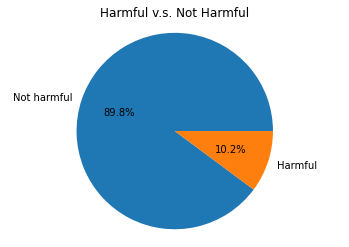

In [8]:
# pie chart for whole dataset
labels = ['Not harmful', 'Harmful']
sizes = [143346, 16225]

fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, autopct='%1.1f%%')
ax.axis('equal')  # Equal aspect ratio ensures the pie chart is circular.
ax.set_title('Harmful v.s. Not Harmful')


plt.show()

c:\users\willi\appdata\local\programs\python\python38\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


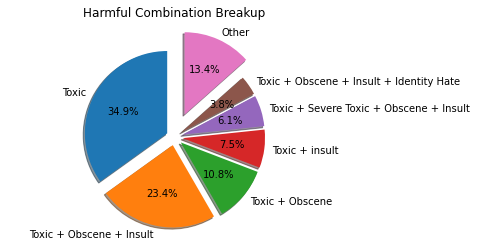

In [9]:
# pie chart Harmful Dataset
labels = ['Toxic', 'Toxic + Obscene + Insult', 'Toxic + Obscene', 'Toxic + insult', 'Toxic + Severe Toxic + Obscene + Insult', 'Toxic + Obscene + Insult + Identity Hate', 'Other']
sizes = [5666, 3800, 1758, 1215, 989, 618, 2179]

explode = (0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.3)

fig, ax = plt.subplots()
ax.pie(sizes,
       explode=explode,
       labels=labels,
       autopct='%1.1f%%',
       shadow=True,
       startangle=90)
ax.axis('equal')  # Equal aspect ratio ensures the pie chart is circular.
ax.set_title('Harmful Combination Breakup')
plt.show()

# Data Cleaning

In [10]:
def prepossess(df):
    def remove_punctuation(text):
        #return str(text).translate(str.maketrans('', '', string.punctuation))
        text_nopunct = "".join([char for char in str(text) if char not in string.punctuation])
        return text_nopunct

    def tokenize_text(text):
        tokens = nltk.word_tokenize(text) 
        tokens = [token.strip() for token in tokens]
        return tokens

    def remove_stopwords(tokens):
        stopword_list = nltk.corpus.stopwords.words('english')
        filtered_tokens = [token for token in tokens if token not in stopword_list]
        #filtered_text = ' '.join(filtered_tokens)    
        return filtered_tokens

    def expand_contractions(text, contraction_mapping):

        contractions_pattern = re.compile('({})'.format('|'.join(contraction_mapping.keys())), 
                                          flags=re.IGNORECASE|re.DOTALL)
        def expand_match(contraction):
            match = contraction.group(0)
            first_char = match[0]
            expanded_contraction = contraction_mapping.get(match)\
                                    if contraction_mapping.get(match)\
                                    else contraction_mapping.get(match.lower())                       
            expanded_contraction = first_char+expanded_contraction[1:]
            return expanded_contraction

        expanded_text = contractions_pattern.sub(expand_match, text)
        expanded_text = re.sub("'", "", expanded_text)
        return expanded_text
    def remove_digit(text):
        text_nodigit = re.sub(r'\w*\d\w*', '',text).strip()
        return text_nodigit

    def stemming(tokenized_text):
        ps = nltk.PorterStemmer()
        stemmed = [ps.stem(word) for word in tokenized_text]
        return stemmed

    def lemmatize(tokenized_text):
        wn = nltk.WordNetLemmatizer()
        lemmatized = [wn.lemmatize(word) for word in tokenized_text]
        return lemmatized
    
    df["comment_text_clean"] = df["comment_text"].apply(lambda x: expand_contractions(x.lower(), util.contraction_mapping))
    df["comment_text_clean"] = df["comment_text_clean"].apply(lambda x: remove_punctuation(x))
    df["comment_text_clean"] = df["comment_text_clean"].apply(lambda x: remove_digit(x))
    df["tokenized"] = df["comment_text_clean"].apply(lambda x: tokenize_text(x))
    df['tokenized'] =  df["tokenized"].apply(lambda x: remove_stopwords(x))
    df['stemmed'] =  df["tokenized"].apply(lambda x: stemming(x))
    df['lemmatized'] =  df["tokenized"].apply(lambda x: lemmatize(x))
    return df

c:\users\willi\appdata\local\programs\python\python38\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [11]:
df_process = prepossess(df_harmful)
df_process.head()

c:\users\willi\appdata\local\programs\python\python38\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-10-52c6a5f248c4>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["comment_text_clean"] = df["comment_text"].apply(lambda x: expand_contractions(x.lower(), util.contraction_mapping))


,comment_text,harmful,comment_text_clean,tokenized,stemmed,lemmatized
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,4,cocksucker before you piss around on my work,"[cocksucker, piss, around, work]","[cocksuck, piss, around, work]","[cocksucker, piss, around, work]"
12,Hey... what is it..\n@ | talk .\nWhat is it......,1,hey what is it\n talk \nwhat is it an exclusi...,"[hey, talk, exclusive, group, wp, talibanswho,...","[hey, talk, exclus, group, wp, talibanswho, go...","[hey, talk, exclusive, group, wp, talibanswho,..."
16,"Bye! \n\nDon't look, come or think of comming ...",1,bye \n\ndo not look come or think of comming b...,"[bye, look, come, think, comming, back, tosser]","[bye, look, come, think, com, back, tosser]","[bye, look, come, think, comming, back, tosser]"
42,You are gay or antisemmitian? \n\nArchangel WH...,4,you are gay or antisemmitian \n\narchangel whi...,"[gay, antisemmitian, archangel, white, tiger, ...","[gay, antisemmitian, archangel, white, tiger, ...","[gay, antisemmitian, archangel, white, tiger, ..."
43,"FUCK YOUR FILTHY MOTHER IN THE ASS, DRY!",3,fuck your filthy mother in the ass dry,"[fuck, filthy, mother, ass, dry]","[fuck, filthi, mother, ass, dri]","[fuck, filthy, mother, as, dry]"


## Percentage of Changing After Each Step

### From Tokenization to Stopwords Removal

In [ ]:
# From Tokenization to Stopwords Removal
tokenization = df_process['tokenized'].values.tolist()
count = 0
for words in tokenization:
    count += len(words)
count_srRemoval = 0
stopwords_removal = df_process['remove_stopwords']
for words in stopwords_removal:
    count_srRemoval += len(words)
total_stopwords_removed = count - count_srRemoval
percentage_change_after_sr = total_stopwords_removed / count
print('Total stopwords removed', total_stopwords_removed)
print('Percentage of Change After Stopwords Removal', percentage_change_after_sr)

### From Stopwords Removal to Stemming

In [ ]:
# From Stopwords Removal to Stemming
df_process['unchange_SR_Stemming'] = [list(set(a).intersection(set(b))) 
                      for a, b in zip(df_process.remove_stopwords, df_process.stemmed)]

SR = df_process['remove_stopwords'].values.tolist()
count_SR = 0
for words in SR:
    count_SR += len(words)

unchange_SR_Stemming = df_process['unchange_SR_Stemming'].values.tolist()
count_unchange_SR_Stemming = 0
for words in unchange_SR_Stemming:
    count_unchange_SR_Stemming += len(words)

count_change_SR_Stemming = count_SR-count_unchange_SR_Stemming
print('Total words after removing stopwords:', count_SR)
print('Total words that are NOT changed during stemming process:', count_unchange_SR_Stemming)
print('Total words that are changed after stemming process:', count_change_SR_Stemming)
print('Percentage of words that are not changed during stemming process',count_unchange_SR_Stemming/count_SR)
print('Percentage of words that are changed during stemming process', count_change_SR_Stemming/count_SR)

### From Stemming to Lemmatization

In [ ]:
# From Stemming to Lemmatization
df_process['unchange_Stemming_Lemma'] = [list(set(a).intersection(set(b))) 
                      for a, b in zip(df_process.stemmed, df_process.lemmatized)]

SL = df_process['stemmed'].values.tolist()
count_SL = 0
for words in SL:
    count_SL += len(words)

unchange_Stemming_Lemma = df_process['unchange_Stemming_Lemma'].values.tolist()
count_unchange_Stemming_Lemma = 0
for words in unchange_Stemming_Lemma:
    count_unchange_Stemming_Lemma += len(words)

count_change_Stemming_Lemma = count_SL-count_unchange_Stemming_Lemma
print('Total words after stemming:', count_SL)
print('Total words that are NOT changed during lemmatization process:', count_unchange_Stemming_Lemma)
print('Total words that are changed after lemmatization process:', count_change_Stemming_Lemma)
print('Percentage of words that are not changed during lemmatization process',count_unchange_Stemming_Lemma/count_SL)
print('Percentage of words that are changed during lemmatization process', count_change_Stemming_Lemma/count_SL)

# LDA

In [13]:
def token_to_corpus(token):
    data_words = token.values.tolist()
    #print(data_words[:1][0][:30])
    id2word = corpora.Dictionary(data_words)
    # Create Corpus
    texts = data_words
    # Term Document Frequency
    corpus = [id2word.doc2bow(text) for text in texts]  
    return corpus, id2word

def generate_pyLDAvis(corpus, id2word,num_topics = 10, save = False):
    lda_model = LdaModel(corpus = corpus,
                     id2word = id2word,
                     num_topics = num_topics,
                     random_state = 0,
                     chunksize = 100,
                     alpha = "auto",
                     per_word_topics = True,
    )
    LDA_vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
    if(save):
        pyLDAvis.save_html(LDA_vis, "./results/pyLDAvis.html")
    pprint(lda_model.print_topics())
    return LDA_vis




c:\users\willi\appdata\local\programs\python\python38\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [15]:
complete_corpus, complete_id2word = token_to_corpus(df_process['lemmatized'])
complete_LDA_vis = generate_pyLDAvis(complete_corpus, complete_id2word, save = True)



c:\users\willi\appdata\local\programs\python\python38\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(0,
  '0.246*"suck" + 0.211*"nigger" + 0.079*"fucker" + 0.065*"cock" + '
  '0.026*"others" + 0.021*"kill" + 0.018*"slap" + 0.018*"ball" + 0.016*"hard" '
  '+ 0.015*"notrhbysouthbanof"'),
 (1,
  '0.326*"aid" + 0.090*"guy" + 0.063*"chicken" + 0.052*"gay" + 0.016*"p" + '
  '0.014*"dumb" + 0.013*"section" + 0.011*"neiln" + 0.011*"c" + 0.011*"fool"'),
 (2,
  '0.053*"like" + 0.046*"hate" + 0.031*"dog" + 0.019*"article" + 0.017*"bad" + '
  '0.016*"hell" + 0.013*"need" + 0.013*"said" + 0.013*"jones" + 0.012*"also"'),
 (3,
  '0.046*"fat" + 0.035*"stupid" + 0.025*"wikipedia" + 0.025*"page" + '
  '0.021*"know" + 0.017*"fag" + 0.016*"love" + 0.014*"one" + 0.013*"vagina" + '
  '0.012*"talk"'),
 (4,
  '0.125*"cocksucker" + 0.118*"mothjer" + 0.057*"shut" + 0.025*"piss" + '
  '0.023*"stay" + 0.019*"respect" + 0.017*"useless" + 0.014*"bye" + '
  '0.013*"wikipedians" + 0.012*"worth"'),
 (5,
  '0.056*"fucking" + 0.038*"get" + 0.034*"shit" + 0.023*"as" + 0.022*"stop" + '
  '0.019*"bastard" + 0.017*"dick"

<ipython-input-13-c06558e32122>:22: ResourceWarning: unclosed file <_io.TextIOWrapper name='./results/pyLDAvis.html' mode='w' encoding='cp936'>
  pyLDAvis.save_html(LDA_vis, "./results/pyLDAvis.html")


In [14]:
simple_corpus, simple_id2word = token_to_corpus(df_process['lemmatized'][:100])
simple_LDA_vis = generate_pyLDAvis(simple_corpus, simple_id2word)
pyLDAvis.enable_notebook()
simple_LDA_vis

c:\users\willi\appdata\local\programs\python\python38\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(0,
  '0.020*"fucking" + 0.013*"wikipedia" + 0.010*"shut" + 0.008*"anymore" + '
  '0.007*"time" + 0.007*"stupid" + 0.007*"hardy" + 0.007*"mother" + '
  '0.006*"say" + 0.005*"curse"'),
 (1,
  '0.010*"see" + 0.009*"world" + 0.007*"fun" + 0.007*"think" + 0.007*"page" + '
  '0.007*"look" + 0.006*"people" + 0.006*"ride" + 0.006*"adult" + 0.006*"u"'),
 (2,
  '0.013*"fuck" + 0.010*"go" + 0.009*"say" + 0.008*"page" + 0.008*"mother" + '
  '0.008*"shit" + 0.007*"fucker" + 0.007*"block" + 0.006*"piece" + '
  '0.006*"get"'),
 (3,
  '0.011*"page" + 0.010*"see" + 0.009*"know" + 0.008*"talk" + 0.008*"go" + '
  '0.007*"sorry" + 0.006*"jong" + 0.006*"un" + 0.006*"wp" + 0.006*"thing"'),
 (4,
  '0.022*"like" + 0.014*"one" + 0.010*"capoeira" + 0.008*"edits" + '
  '0.008*"stupid" + 0.008*"also" + 0.007*"look" + 0.007*"want" + 0.006*"care" '
  '+ 0.006*"people"'),
 (5,
  '0.016*"wikipedia" + 0.012*"right" + 0.011*"people" + 0.009*"get" + '
  '0.008*"like" + 0.008*"god" + 0.008*"men" + 0.008*"muslim" + 0.00

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6     -0.057172  0.001405       1        1  17.388562
1      0.047267  0.074136       2        1  15.740674
5     -0.051756 -0.089244       3        1  15.158425
4      0.147813 -0.071345       4        1  14.818716
3      0.029057  0.011064       5        1   8.973919
8      0.019288  0.066112       6        1   8.931355
9     -0.027887  0.055662       7        1   7.042497
0     -0.032016 -0.011648       8        1   4.377733
7     -0.048196 -0.051906       9        1   4.364599
2     -0.026398  0.015763      10        1   3.203522, topic_info=           Term       Freq      Total Category  logprob  loglift
90         fuck  12.000000  12.000000  Default  30.0000  30.0000
52      fucking   8.000000   8.000000  Default  29.0000  29.0000
112         get  11.000000  11.000000  Default  28.0000  28.0000
248   wikipedia  13.000000  13.000000  Default  27.0000  27.0000
193        like  14.000000  14.000000  Default  26.0000  26.0000
...         ...        ...        ...      ...      ...      ...
53          gay   0.289608   3.600969  Topic10  -5.5272   0.9205
1056      begin   0.287907   3.437271  Topic10  -5.5331   0.9611
115       right   0.292217   6.189350  Topic10  -5.5182   0.3878
248   wikipedia   0.289379  13.496851  Topic10  -5.5280  -0.4016
1147     father   0.278120   4.145652  Topic10  -5.5676   0.7392

[601 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
253       6  0.775848  absolutely
4         5  0.806749         abt
898       5  0.786210      access
899       5  0.499182    actually
430       2  0.437714         add
...     ...       ...         ...
85        4  0.167579       would
85        6  0.167579       would
85        8  0.167579       would
28        5  0.539479          wp
656       2  0.659657      wpalso

[582 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 2, 6, 5, 4, 9, 10, 1, 8, 3])